In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from pyenzyme.enzymeml.tools import EnzymeMLReader
import json

from utilities.jsonhelper import JSONHelper
from utilities.modeler import Modeler

# initialize helpers
jsonH = JSONHelper("https://enzml.sloppy.zone/")
md = Modeler()

In [2]:
abts = True
if abts:
    path = 'datasets/Sandile/ABTS.omex'
    num_data = 9
else:
    path = 'datasets/Sandile/Syringaldazine.omex'
    num_data = 7

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLReader().readFromFile(path)
else:
    print('Incorrect file path.')

print(enzmlDoc)

>>> Units
	ID: u0 	 Name: ul
	ID: u1 	 Name: K
	ID: u2 	 Name: umole / l
	ID: u3 	 Name: sec
>>> Reactants
	ID: s0 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid)
	ID: s1 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid) radicals
	ID: s2 	 Name: O2
	ID: s3 	 Name: H2O
>>> Proteins
	ID: p0 	 Name: laccase 2 (lap2)
>>> Reactions
	ID: r0 	 Name: Oxidation


In [3]:
reaction = enzmlDoc.getReaction('r0')
reaction_name = reaction.getName()
replicates = reaction.getEduct('s0')[3]
data = []
init_co = []
time = []
for replicate in replicates:
    time = replicate.getData().index.values
    data.append(replicate.getData().values.tolist())
    init_co.append(enzmlDoc.getConcDict()[replicate.getInitConc()][0])
data = np.array(data)
init_conc = np.array(init_co)
print(data.shape)

(27, 21)


In [4]:
prot = enzmlDoc.getProtein('p0')
E_conc = prot.getInitConc()
E_conc = np.full(init_conc.shape, E_conc)

In [5]:
w = np.append(init_conc, E_conc).reshape((2,init_conc.shape[0]))
w = np.transpose(w)

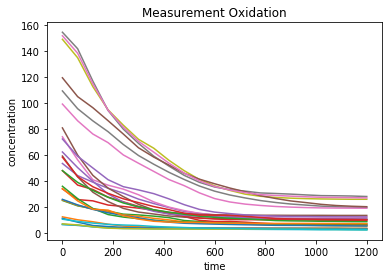

In [6]:
# plot time course data with matplotlib
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    ax.plot(time, data[i, :], label='repl '+str(i+1))
plt.title('Measurement '+reaction_name)
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

In [7]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation
    Arguments:
        w: vector of state variables: w = [S,E]
        t: time
        params: parameters object from lmfit
    '''
    S = w
    
    kcat = params['kcat'].value
    E = params['E'].value
    Km = params['Km'].value
    bias = params['Sb'].value
    
    # f(S'):
    f = -kcat*E*(S-bias)/(Km+S-bias) # dS/dt
    
    return f

def meten_with_substrat_dependent_enzymeinaktivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [S,E]
        t: time
        params: parameters object from lmfit
    '''
    S, E = w
    
    kcat = params['kcat'].value
    Km = params['Km'].value
    k_E = params['k_E'].value
    bias = params['Sb'].value
    
    # f(S', E'):
    dS = -kcat*E*(S-bias)/(Km+S-bias)
    dE = -k_E*E*S
    
    return (dS, dE)

def meten_with_enzymeinaktivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [S,E]
        t: time
        params: parameters object from lmfit
    '''
    S, E = w
    
    kcat = params['kcat'].value
    Km = params['Km'].value
    k_E = params['k_E'].value
    bias = params['Sb'].value
    
    # f(S', E'):
    dS = -kcat*E*(S-bias)/(Km+S-bias)
    dE = -k_E*E
    
    return (dS, dE)

In [8]:
def residual(params, t, data, w, f):
    '''
    Calculates residual between measured data and modeled data

    Args:
        params: parameters object from lmfit
        t: time
        data: measured data
        f: ODEs
    '''
    try:
        w.shape[1]
        bias = np.array([params['Sb'].value,0])
        w = np.add(w, bias)
    except IndexError:
        bias = np.array([params['Sb'].value])
        w = np.add(w, bias)
    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        model = md.solveODE(f, t, w[i], params)
        s_model = model[:,0]
        residual[i,:]=data[i,:]-s_model
    return residual.flatten()

In [9]:
if num_data==9:
    colors = ['#252525','#999999','#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a','#377eb8']
elif num_data==7:
    colors = ['#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a','#377eb8']
else:
    print('Wrong data!')
#e31a1c

# Model 1a: irreversible Michaelis Menten

In [10]:
#bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = init_conc # shape(27,1)
print(w.shape)

params = Parameters()
params.add('E', value=E, vary=False)
params.add('kcat', value=kcat, min=0.0001, max=1000)
params.add('Km', value=km, min=0.0001, max=np.max(data)*100)
params.add('Sb', value=0, vary=False)

(27,)


In [11]:
result_menten = minimize(residual , params, args=(time, data, w, irreversible_Michaelis_Menten), method='leastsq')

In [12]:
report_fit(result_menten)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 567
    # variables        = 2
    chi-square         = 19024.0186
    reduced chi-square = 33.6708294
    Akaike info crit   = 1995.92673
    Bayesian info crit = 2004.60745
[[Variables]]
    E:     0.93 (fixed)
    kcat:  37.0325826 +/- 257.087329 (694.22%) (init = 0.4469359)
    Km:    15439.0219 +/- 13591.6804 (88.03%) (init = 15.26874)
    Sb:    0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km) =  1.000


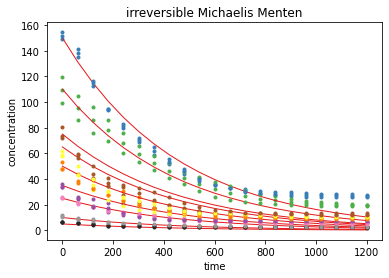

In [13]:
plt.figure()
ax = plt.subplot()
ax.clear()
for i in range(data.shape[0]):
    data_fitted1a = md.solveODE(irreversible_Michaelis_Menten, time, w[i], result_menten.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted1a[:], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis Menten')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

# Model 1b: irreversible Michaelis Menten with bias

In [14]:
bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = init_conc # shape(27,1)
print(w.shape)

params = Parameters()
params.add('E', value=E, vary=False)
params.add('kcat', value=kcat, min=0.0001, max=1000)
params.add('Km', value=km, min=0.0001, max=np.max(data)*100)
params.add('Sb', value=0, min=0.0001, max=np.max(data)*0.5)

(27,)


In [15]:
result_menten_w_bias = minimize(residual , params, args=(time, data, w, irreversible_Michaelis_Menten), method='leastsq')

In [16]:
report_fit(result_menten_w_bias)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 185
    # data points      = 567
    # variables        = 3
    chi-square         = 18933.9515
    reduced chi-square = 33.5708360
    Akaike info crit   = 1995.23596
    Bayesian info crit = 2008.25704
[[Variables]]
    E:     0.93 (fixed)
    kcat:  38.0320162 +/- 269.133562 (707.65%) (init = 0.4469359)
    Km:    15438.9666 +/- 109860.542 (711.58%) (init = 15.26874)
    Sb:    0.65894526 +/- 0.42232179 (64.09%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km) =  1.000
    C(Km, Sb)   = -0.497
    C(kcat, Sb) = -0.495


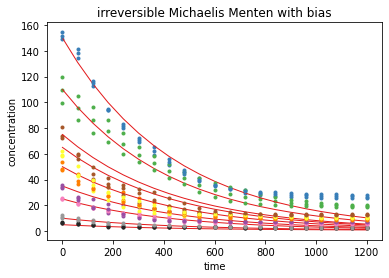

In [17]:
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    data_fitted1b = md.solveODE(irreversible_Michaelis_Menten, time, w[i], result_menten_w_bias.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted1b[:], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis Menten with bias')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

# Model 2a) Menten with enzyme inactivation

In [18]:
#bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = np.append(init_conc, E_conc).reshape((2,init_conc.shape[0]))
w = np.transpose(w)

params = Parameters()
params.add('k_E', value=0.5, min=0.00000001, max=np.max(data))
params.add('kcat', value=kcat, min=0.0001, max=100)
params.add('Km', value=km, min=0.0001, max=np.max(data)*100)
params.add('Sb', value=0, vary=False)

In [19]:
result_inactivation = minimize(residual , params, args=(time, data, w, meten_with_enzymeinaktivation), method='leastsq')

In [20]:
report_fit(result_inactivation)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 567
    # variables        = 3
    chi-square         = 9272.27589
    reduced chi-square = 16.4402055
    Akaike info crit   = 1590.43888
    Bayesian info crit = 1603.45996
[[Variables]]
    k_E:   0.00162998 +/- 7.1873e-05 (4.41%) (init = 0.5)
    kcat:  1.50692720 +/- 0.16580294 (11.00%) (init = 0.4469359)
    Km:    340.396357 +/- 46.9849776 (13.80%) (init = 15.26874)
    Sb:    0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km)  =  0.986
    C(k_E, Km)   = -0.387
    C(k_E, kcat) = -0.241


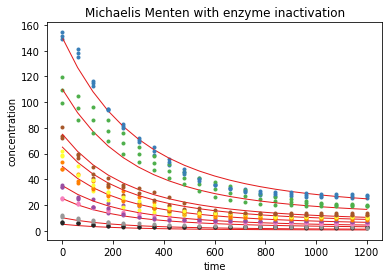

In [21]:
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    data_fitted2a = md.solveODE(meten_with_enzymeinaktivation, time, w[i], result_inactivation.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted2a[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis Menten with enzyme inactivation')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

# Model 2b) Menten with enzymeinactivation and bias

In [22]:
bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = np.append(init_conc, E_conc).reshape((2,init_conc.shape[0]))
w = np.transpose(w)

params = Parameters()
params.add('k_E', value=0.5, min=0.00000001, max=np.max(data))
params.add('kcat', value=kcat, min=0.0001, max=100)
params.add('Km', value=km, min=0.0001, max=np.max(data)*100)
params.add('Sb', value=0, min=-0.00001, max=np.max(data)*0.5)

In [23]:
result_inactivation_w_bias = minimize(residual , params, args=(time, data, w, meten_with_enzymeinaktivation), method='leastsq')

In [24]:
report_fit(result_inactivation_w_bias)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 567
    # variables        = 4
    chi-square         = 8682.74117
    reduced chi-square = 15.4222756
    Akaike info crit   = 1555.19176
    Bayesian info crit = 1572.55319
[[Variables]]
    k_E:   0.00177119 +/- 7.3356e-05 (4.14%) (init = 0.5)
    kcat:  1.04497398 +/- 0.08063791 (7.72%) (init = 0.4469359)
    Km:    190.297948 +/- 22.7747301 (11.97%) (init = 15.26874)
    Sb:    2.02634508 +/- 0.31946788 (15.77%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km)  =  0.970
    C(Km, Sb)    = -0.652
    C(kcat, Sb)  = -0.560
    C(k_E, Km)   = -0.469
    C(k_E, Sb)   =  0.326
    C(k_E, kcat) = -0.271


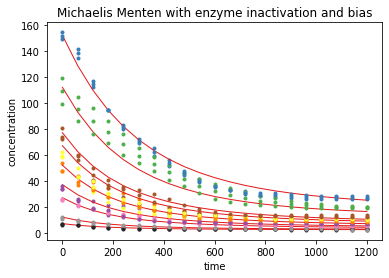

In [25]:
bias = np.array([result_inactivation_w_bias.params['Sb'].value,0])
w = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    data_fitted2b = md.solveODE(meten_with_enzymeinaktivation, time, w[i], result_inactivation_w_bias.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted2b[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis Menten with enzyme inactivation and bias')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

# Model 3a) Menten with substarte dependent enzyme inactivation

In [26]:
#bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = np.append(init_conc, E_conc).reshape((2,init_conc.shape[0]))
w = np.transpose(w)

params = Parameters()
params.add('k_E', value=0.5, min=0.00000001, max=np.max(data))
params.add('kcat', value=kcat, min=0.0001, max=100)
params.add('Km', value=km, min=0.0001, max=np.max(data)*100)
params.add('Sb', value=0, vary=False)

In [27]:
result_substratdep_inactivation = minimize(residual , params, args=(time, data, w, meten_with_substrat_dependent_enzymeinaktivation), method='leastsq')

In [28]:
report_fit(result_substratdep_inactivation)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 197
    # data points      = 567
    # variables        = 3
    chi-square         = 13943.2666
    reduced chi-square = 24.7221038
    Akaike info crit   = 1821.75665
    Bayesian info crit = 1834.77773
[[Variables]]
    k_E:   1.3847e-05 +/- 1.0091e-06 (7.29%) (init = 0.5)
    kcat:  48.9877854 +/- 259.045843 (528.80%) (init = 0.4469359)
    Km:    15439.0241 +/- 18079.9510 (117.11%) (init = 15.26874)
    Sb:    0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km)  = -1.000
    C(k_E, kcat) =  0.312
    C(k_E, Km)   = -0.308


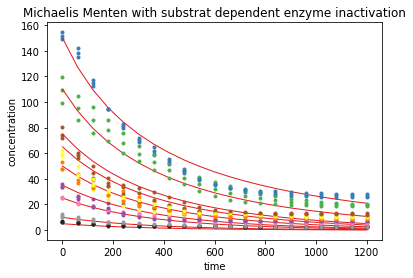

In [29]:
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    data_fitted3a = md.solveODE(meten_with_substrat_dependent_enzymeinaktivation, time, w[i], result_substratdep_inactivation.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted3a[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis Menten with substrat dependent enzyme inactivation')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

# Model 3b: Menten with substarte dependent enzyme inactivation and bias

In [30]:
bias = md.get_initial_bias(data)
vmax = md.get_initial_vmax(time, data)
E = E_conc[0]
kcat = vmax/E
km = md.get_initial_Km(time, data)

w = np.append(init_conc, E_conc).reshape((2,init_conc.shape[0]))
w = np.transpose(w)

params = Parameters()
params.add('k_E', value=result_substratdep_inactivation.params['k_E'], min=0.00000001, max=np.max(data))
params.add('kcat', value=result_substratdep_inactivation.params['kcat'], min=0.0001, max=100)
params.add('Km', value=result_substratdep_inactivation.params['Km'], min=0.0001, max=np.max(data)*100)
params.add('Sb', value=result_inactivation_w_bias.params['Sb'], min=0.00001, max=np.max(data)*0.5)

In [31]:
result_substratdep_inactivation_w_bias = minimize(residual , params, args=(time, data, w, meten_with_substrat_dependent_enzymeinaktivation), method='leastsq')

In [32]:
report_fit(result_substratdep_inactivation_w_bias)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 567
    # variables        = 4
    chi-square         = 14152.4504
    reduced chi-square = 25.1375674
    Akaike info crit   = 1832.19989
    Bayesian info crit = 1849.56133
[[Variables]]
    k_E:   1.3847e-05 +/- 1.1243e-06 (8.12%) (init = 1.384712e-05)
    kcat:  48.9877854 +/- 330.441980 (674.54%) (init = 48.98779)
    Km:    15439.0241 +/- 104592.263 (677.45%) (init = 15439.02)
    Sb:    2.02634508 +/- 0.37350885 (18.43%) (init = 2.026345)
[[Correlations]] (unreported correlations are < 0.100)
    C(kcat, Km)  =  1.000
    C(Km, Sb)    = -0.432
    C(kcat, Sb)  = -0.429
    C(k_E, kcat) =  0.338
    C(k_E, Km)   =  0.334
    C(k_E, Sb)   =  0.234


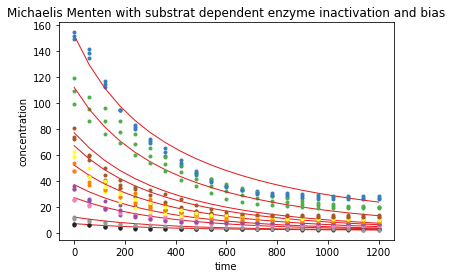

In [33]:
bias = np.array([result_substratdep_inactivation_w_bias.params['Sb'].value,0])
w = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(data.shape[0]):
    data_fitted3b = md.solveODE(meten_with_substrat_dependent_enzymeinaktivation, time, w[i], result_substratdep_inactivation_w_bias.params)
    ax.plot(time, data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i%num_data])
    if i<num_data:
        ax.plot(time, data_fitted3b[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis Menten with substrat dependent enzyme inactivation and bias')
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()